<a href="https://colab.research.google.com/github/ishaterdal/Text-Classification-using-TFIDF/blob/main/Text_Classification_using_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [2]:
!pip install h2o

     |████████████████████████████████| 164.6MB 83kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.3-py2.py3-none-any.whl size=164649662 sha256=cadc39191f445265382249c31a9a1042c10d7d4349ca662e3f9af75f26e7dceb
  Stored in directory: /root/.cache/pip/wheels/0a/fd/63/96d322a27867a81a2904172a75aed5241913d603a4b8c4b277
Successfully built h2o


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp23wy8m26
  JVM stdout: /tmp/tmp23wy8m26/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp23wy8m26/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_t9x8zc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
df=pd.read_csv('https://github.com/ishaterdal/Text-Classification-using-TFIDF/blob/main/consumer_compliants.zip?raw=true', compression='zip', sep=',', quotechar='"')

In [8]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566


In [9]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

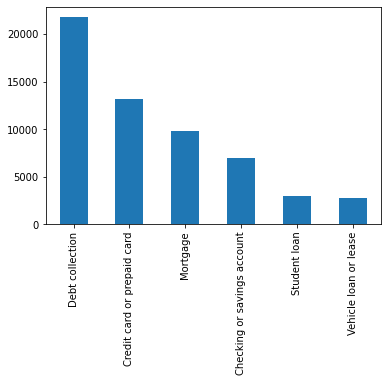

In [10]:
df['Product'].value_counts().plot(kind='bar')

In [11]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
Dana & Pariser Co.,L.P.A.                   1
RELIANCE FIRST CAPITAL LLC                  1
Strada Education Network, Inc.              1
Asset Recovery Inc                          1
CREDIT CONCEPTS, INC.                       1
Name: Company, Length: 2197, dtype: int64

In [12]:
complaints_df=df[['Consumer complaint narrative', 'Product','Company']].rename(columns={'Consumer complaint narrative': 'Complaints'})

In [14]:
pd.set_option('display.max_colwidth', None)
complaints_df

,Complaints,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

In [ ]:
target={'Debt Collection':0}